In [3]:
import numpy as np
import pyximport
pyximport.install(setup_args={'include_dirs': np.get_include()})

from zipline.api import order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target
from zipline.utils.calendars.exchange_calendar_testchinesefutures import ChineseFutures

from collections import OrderedDict
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import style

import zipline
import pytz

style.use('ggplot')

%matplotlib inline
%load_ext zipline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


In [7]:
import sys
sys.executable

'/Users/miaoyuesun/anaconda3/bin/python'

In [8]:
import tensorflow

/Users/miaoyuesun/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [9]:
loc = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/"

In [161]:
start_date = pd.to_datetime('12/1/2017').tz_localize('UTC')
end_date = pd.to_datetime('12/1/2018').tz_localize('UTC')

data = OrderedDict()
tickers = ['jm000', 'j9000']

for ticker in tickers:
    data[ticker] = pd.read_csv(loc+"{}.csv".format(ticker))
    data[ticker].columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interests']
    data[ticker]['date'] = pd.to_datetime(data[ticker]['date'])
    data[ticker].set_index('date', inplace = True)
    data[ticker] = data[ticker].resample('D').last()
    data[ticker].fillna(method = 'ffill', inplace=True)
    data[ticker] = data[ticker][['open', 'high', 'low', 'close', 'volume']]
    print('Ticker', ticker)
    print(data[ticker].head())
    
    


# data['BTC'] = pd.read_csv("{}.csv")

# data['BTC']['date'] = pd.to_datetime(data['BTC']['time'], unit='s', utc=True)
# data['BTC'].set_index('date', inplace=True)
# data['BTC'].drop('time', axis=1, inplace=True)
# data['BTC'] = data['BTC'].resample("1min").mean()
# data['BTC'].fillna(method="ffill", inplace=True)
# data['BTC'] = data['BTC'][["low","high","open","close","volume"]]
# print(data['BTC'].head())

# panel = pd.Panel(data)
# panel.minor_axis = ["low","high","open","close","volume"]
# panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
# print(panel)

Ticker jm000
              open    high     low   close    volume
date                                                
2013-03-22  1270.0  1282.0  1263.0  1268.0  191864.0
2013-03-23  1270.0  1282.0  1263.0  1268.0  191864.0
2013-03-24  1270.0  1282.0  1263.0  1268.0  191864.0
2013-03-25  1263.0  1265.0  1256.0  1259.0  162280.0
2013-03-26  1269.0  1277.0  1268.0  1273.0  214850.0
Ticker j9000
              open    high     low   close   volume
date                                               
2011-04-15  2241.0  2252.0  2239.0  2250.0   6710.0
2011-04-16  2241.0  2252.0  2239.0  2250.0   6710.0
2011-04-17  2241.0  2252.0  2239.0  2250.0   6710.0
2011-04-18  2375.0  2389.0  2366.0  2382.0  32780.0
2011-04-19  2349.0  2354.0  2327.0  2337.0  36446.0


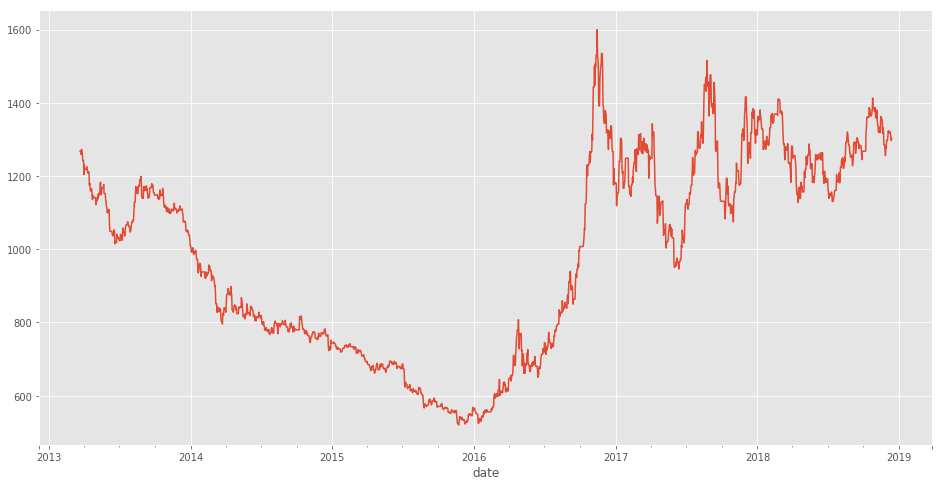

In [162]:
data['jm000']['close'].plot(figsize = (16, 8))

In [167]:
panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
# panel.major_axis = panel.major_axis.tz_localize(pytz.timezone('Asia/Shanghai'))
panel.major_axis = panel.major_axis.tz_localize(pytz.timezone('UTC'))
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 2800 (major_axis) x 5 (minor_axis)
Items axis: jm000 to j9000
Major_axis axis: 2011-04-15 00:00:00+00:00 to 2018-12-13 00:00:00+00:00
Minor_axis axis: open to volume


In [318]:
import time
start = time.time()

bar_count_slow_dict = [5]
bar_count_fast_dict = [3]
bt_count = 0

optimization_record = {'backtest_count': [],
                       'parameter_1': [],
                       'parameter_2': [],
                       'sharpe': []
                      }


def initialize(context):
    set_benchmark(symbol("jm000"))


def handle_data(context, data):

    slowma = data.history(symbol("j9000"), fields='price', bar_count=bar_count_slow, frequency='1d').mean()
    fastma = data.history(symbol("j9000"), fields='price', bar_count=bar_count_fast, frequency='1d').mean()


    if fastma < slowma:
        if symbol("j9000") not in get_open_orders():
            order_target(symbol("j9000"), -1)

    if fastma > slowma:
        if symbol("j9000") not in get_open_orders():
            order_target(symbol("j9000"), 1)

    record(j9000=data.current(symbol('j9000'), fields='price'),
           signal=fastma-slowma,
           fastma = fastma,
           slowma = slowma)
    

    
for bar_count_fast in bar_count_fast_dict:
    for bar_count_slow in bar_count_slow_dict:
        perf = zipline.run_algorithm(
        #                   start=datetime(2017, 12, 3, 0, 0, 0, 0, pytz.timezone('Asia/Shanghai')),
        #                   end=datetime(2018, 11, 1, 0, 0, 0, 0, pytz.timezone('Asia/Shanghai')),
                          start = start_date,
                          end = end_date,
                          initialize=initialize,
                          trading_calendar=ChineseFutures(),
                          capital_base=10000,
                          handle_data=handle_data,
                          data_frequency ='daily',
                          data=panel)
        bt_count = bt_count + 1
        sharpe_ratio = perf['sharpe'].mean()
        
        optimization_record['backtest_count'].append(bt_count)
        optimization_record['parameter_1'].append(bar_count_fast)
        optimization_record['parameter_2'].append(bar_count_slow)
        optimization_record['sharpe'].append(sharpe_ratio)
        print ("Backtest {} done.".format(bt_count))
        
end = time.time()
print("Time spent on this backtest: ", end - start)

Backtest 1 done.
Time spent on this backtest:  2.4002511501312256


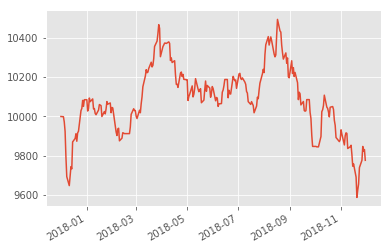

In [319]:
perf.portfolio_value.plot()

In [320]:
perf.columns

Index(['algo_volatility', 'algorithm_period_return', 'alpha',
       'benchmark_period_return', 'benchmark_volatility', 'beta',
       'capital_used', 'ending_cash', 'ending_exposure', 'ending_value',
       'excess_return', 'fastma', 'gross_leverage', 'j9000', 'long_exposure',
       'long_value', 'longs_count', 'max_drawdown', 'max_leverage',
       'net_leverage', 'orders', 'period_close', 'period_label', 'period_open',
       'pnl', 'portfolio_value', 'positions', 'returns', 'sharpe',
       'short_exposure', 'short_value', 'shorts_count', 'signal', 'slowma',
       'sortino', 'starting_cash', 'starting_exposure', 'starting_value',
       'trading_days', 'transactions', 'treasury_period_return'],
      dtype='object')

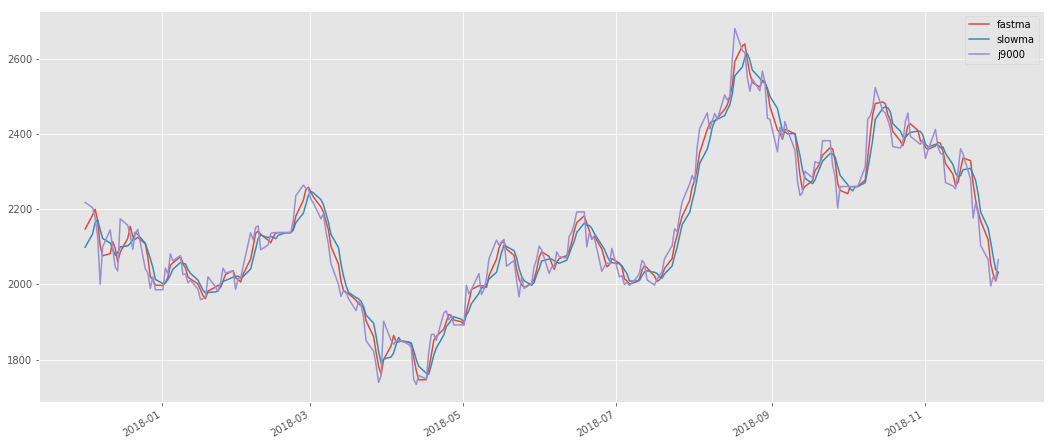

In [323]:
perf[['fastma', 'slowma', 'j9000']].plot(figsize = (18, 8))

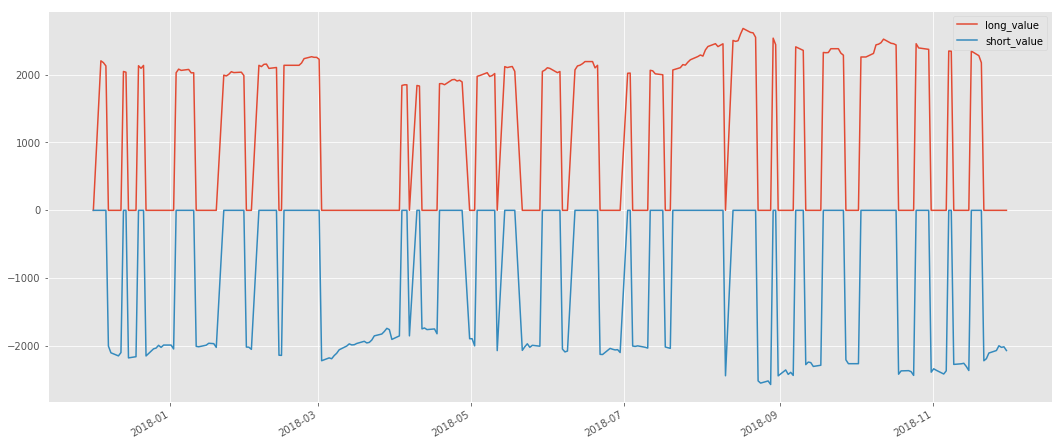

In [324]:
perf[['long_value', 'short_value']].plot(figsize = (18, 8))

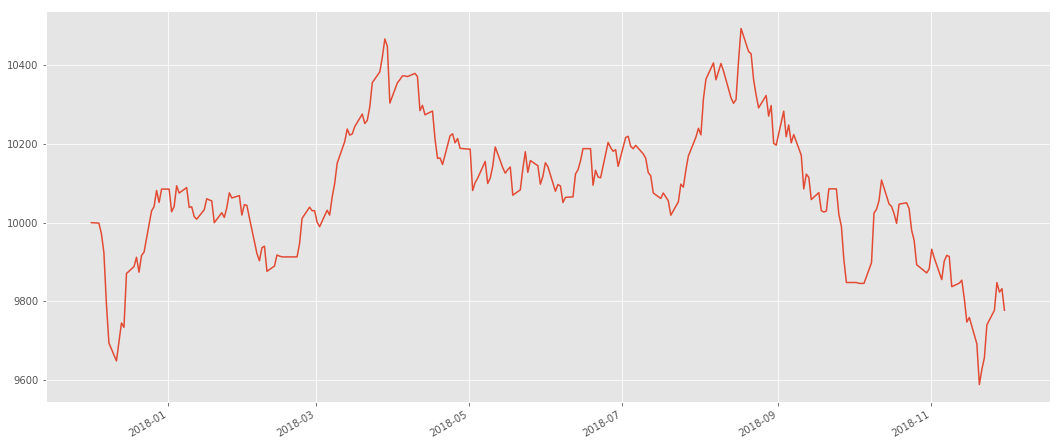

In [326]:
perf['portfolio_value'].plot(figsize = (18, 8))

In [212]:
bt_record_df = pd.DataFrame(optimization_record)

para_1 = bt_record_df['parameter_1']
para_2 = bt_record_df['parameter_2']
sharpe = bt_record_df['sharpe']

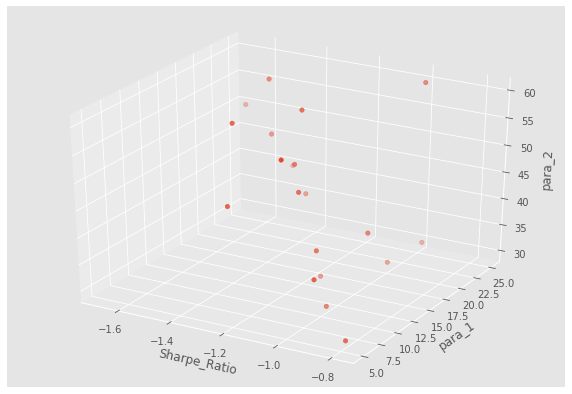

In [236]:
threedee = plt.figure(figsize=(10, 7)).gca(projection='3d')
threedee.scatter(sharpe, para_1, para_2)
threedee.set_xlabel('Sharpe_Ratio')
threedee.set_ylabel('para_1')
threedee.set_zlabel('para_2')
plt.show()

In [180]:
data['j9000'].index

Timestamp('2011-04-15 00:00:00', freq='D')

In [183]:
data['j9000'][data['j9000'].index>='2017-11-30 07:00:00+00:00'].head()

,open,high,low,close,volume
date,,,,,
2017-12-01,2197.5,2218.0,2192.5,2218.0,56464.0
2017-12-02,2197.5,2218.0,2192.5,2218.0,56464.0
2017-12-03,2197.5,2218.0,2192.5,2218.0,56464.0
2017-12-04,2199.5,2206.5,2190.5,2203.5,25812.0
2017-12-05,2160.0,2179.5,2157.0,2177.0,33440.0


In [173]:
perf.index

DatetimeIndex(['2017-12-01 07:00:00+00:00', '2017-12-04 07:00:00+00:00',
               '2017-12-05 07:00:00+00:00', '2017-12-06 07:00:00+00:00',
               '2017-12-07 07:00:00+00:00', '2017-12-08 07:00:00+00:00',
               '2017-12-11 07:00:00+00:00', '2017-12-12 07:00:00+00:00',
               '2017-12-13 07:00:00+00:00', '2017-12-14 07:00:00+00:00',
               ...
               '2018-11-19 07:00:00+00:00', '2018-11-20 07:00:00+00:00',
               '2018-11-21 07:00:00+00:00', '2018-11-22 07:00:00+00:00',
               '2018-11-23 07:00:00+00:00', '2018-11-26 07:00:00+00:00',
               '2018-11-27 07:00:00+00:00', '2018-11-28 07:00:00+00:00',
               '2018-11-29 07:00:00+00:00', '2018-11-30 07:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=261, freq=None)

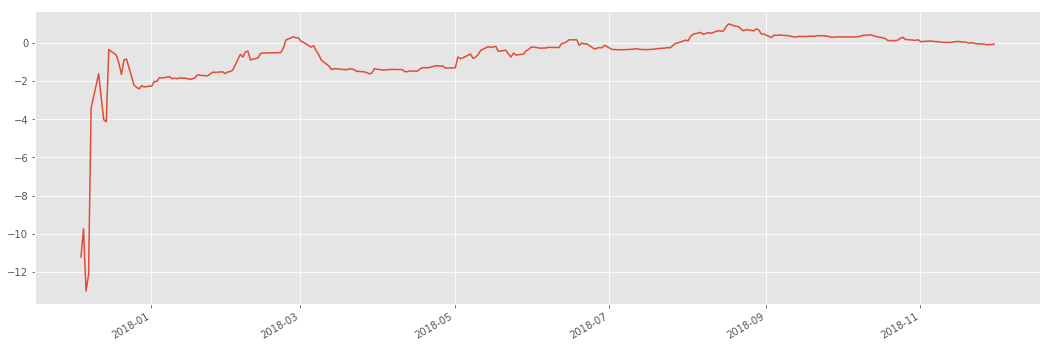

In [116]:
perf['sharpe'].plot(figsize = (18, 6))

In [118]:
perf['sharpe'].mean()

-0.6595349563648444

# Create a function to optimize backtest metrics

In [ ]:
parameters = 

In [190]:
import tensorflow

ImportError: No module named 'tensorflow'

In [185]:
import sys
sys.version

'3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:30:03) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [330]:
import sys
sys.executable


'/Users/miaoyuesun/anaconda3/bin/python'

In [8]:
from jupyter_core.paths import jupyter_data_dir
print(jupyter_data_dir())

/Users/miaoyuesun/Library/Jupyter
